## Assignment 03

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana

In [1]:
%load_ext tensorboard

> Please run the cells below that contain the `%tensorflow` magic command to load the graphs. In case you notice missing information in the grahs, please click on the "**Reload**" button to the top right corner of Tensorboard (you might need to click a couple of times). Otherwise the content will update itself after 30 seconds.

### 0.1 Imports

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10


### 0.2 Environment Information

In [3]:
# def random_seed(seed_value, use_cuda):
#     np.random.seed(seed_value)  # cpu vars
#     torch.manual_seed(seed_value)  # cpu  vars
#     random.seed(seed_value)  # Python
#     if use_cuda:
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value)  # gpu vars
#         torch.backends.cudnn.deterministic = True  # needed
#         torch.backends.cudnn.benchmark = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = "~/.datasets"
seed = 42

seed_everything(seed)

print("Device:", device)
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
print("Data Dir:", data_dir)
print("Set Random Seed:", seed)


Device: cuda:0
Device Name: GeForce GTX 1660 Ti
Data Dir: ~/.datasets
Set Random Seed: 42


## 1.1 Confusion Matrix

In [4]:
def confusion_matrix(predicted: torch.Tensor, targets: torch.Tensor):
    stacked = torch.stack((targets, predicted), dim=1)
    cm_tensor = torch.zeros(10, 10, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cm_tensor[tl, pl] = cm_tensor[tl, pl] + 1
    return cm_tensor


def plot_confusion_matrix(predicted, targets, title="", normalize=True):
    cf_matrix = confusion_matrix(predicted=predicted, targets=targets).cpu().numpy()
    if normalize:
        cf_matrix = (
            cf_matrix.astype("float") / (cf_matrix.sum(axis=1) + 1)[:, np.newaxis]
        )
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()


## 1.2 GenericNeuralNet
---

Inheriting from pytorch-lightning's `LightningModule` class, we add functionality to choose loss function, optimizer, regularization, batch size, etc

In [5]:
# Utils

cifar10_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
)


class GenericNeuralNet(LightningModule):
    def __init__(
        self,
        loss_fn,
        optimizer,
        l1_lambda=None,
        l2_lambda=None,
        batch_size=64,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.loss = loss_fn
        self.l1_lambda = l1_lambda
        self.l2_labmda = l2_lambda
        self.optimizer = optimizer
        self.batch_size = batch_size

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss(y_hat, y)

        # Regularization
        if self.l1_lambda:
            l1_loss = 0
            for param in self.parameters():
                l1_loss += torch.sum(torch.abs(param))
            loss += self.l1_lambda * l1_loss

        if self.l2_labmda:
            l2_loss = 0
            for param in self.parameters():
                l2_loss += torch.norm(param, 2)
            loss += self.l2_labmda * l2_loss

        labels_hat = torch.argmax(y_hat, dim=1)
        train_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        tensorboard_logs = {"train_loss": loss.item(), "train_acc": train_acc}
        return {"loss": loss, "log": tensorboard_logs}

    def configure_optimizers(self):
        optimizers = {
            "SGD": torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9),
            "SGD_no_momentum": torch.optim.SGD(self.parameters(), lr=0.001),
            "Adam": torch.optim.Adam(self.parameters(), lr=0.001),
            "Adagrad": torch.optim.Adagrad(self.parameters(), lr=0.001),
            "Adadelta": torch.optim.Adadelta(self.parameters(), lr=0.001),
            "RMSprop": torch.optim.RMSprop(self.parameters(), lr=0.001),
        }

        optimizer = optimizers.get(self.optimizer)

        if optimizer is None:
            raise Exception(f"Unknown Optimizer: Available {optimizers.keys()}")

        return optimizer

    def train_dataloader(self):
        dataset = CIFAR10(
            data_dir, train=True, download=True, transform=cifar10_transforms
        )
        loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            drop_last=True,
            num_workers=4,
            shuffle=True,
        )
        return loader

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        labels_hat = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        return {"val_loss": self.loss(y_hat, y), "val_acc": torch.tensor(val_acc)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "val_acc": avg_acc, "log": tensorboard_logs}

    def val_dataloader(self):
        dataset = CIFAR10(
            data_dir, train=False, download=True, transform=cifar10_transforms
        )
        loader = DataLoader(
            dataset, batch_size=self.batch_size, drop_last=True, num_workers=4
        )
        return loader


## 1.3 SequentialLinearNetwork
---

Inheriting from `GenericNeuralNet` class, we create a class to create a sequence of fully connected layers interleaved with activation and dropout layers

In [6]:
class SequentialLinearNetwork(GenericNeuralNet):
    def __init__(
        self,
        num_layers: int,
        input_size: int,
        output_size: int,
        activation,
        dropout=True,
        **kwargs,
    ):
        super().__init__(**kwargs)

        _layers = []
        for index, _linear_layer in enumerate(
            self.get_linear_layer(input_size, output_size, num_layers)
        ):
            _layers.append(_linear_layer)
            if index + 1 != num_layers:
                _layers.append(activation())
                if dropout:
                    _layers.append(torch.nn.Dropout(0.2))

        self.model = torch.nn.Sequential(*_layers)

    def get_linear_layer(self, input_size, output_size, num_layers):
        if num_layers < 2:
            raise Exception("num_layers should be >= 2")

        hidden_size = 64

        yield torch.nn.Linear(input_size, hidden_size)

        for _ in range(num_layers - 2):
            yield torch.nn.Linear(hidden_size, hidden_size)

        yield torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

    @torch.no_grad()
    def get_all_preds(self):
        all_preds = torch.tensor([]).to(device)
        labels = torch.tensor([], dtype=torch.int64).to(device)
        for x, y in self.val_dataloader():
            x, y = x.to(device), y.to(device)
            y_hat = self(x)
            all_preds = torch.cat((all_preds, y_hat), dim=0)
            labels = torch.cat((labels, y), dim=0)
        pred_labels = all_preds.argmax(dim=1)
        return pred_labels, labels


## 1.4 Experiment Runner

In [7]:
def run_experiment(
    tensorboard_graph_name, confusion_matrix_title=None, max_epochs=50, **kargs
):

    experiment = SequentialLinearNetwork(input_size=3 * 32 * 32, output_size=10, **kargs,)

    logger = TensorBoardLogger("lightning_logs", name=tensorboard_graph_name)
    trainer = Trainer(
        gpus=1,
        num_nodes=1,
        deterministic=True,
        max_epochs=max_epochs,
        logger=logger,
        progress_bar_refresh_rate=0,
    )
    trainer.fit(experiment)

    if confusion_matrix_title:
        predicted, targets = experiment.get_all_preds()
        plot_confusion_matrix(
            predicted=predicted, targets=targets, title=confusion_matrix_title,
        )

## 2. Task: Experiment With Different Layer Sizes
---
We wantest to observe the behaviour with no regularization, with regulatization and increasing the regularizing term values

### Observation:


In all the three setups, with hidden_layer_size=64 and training for 50 epochs, we noticed a degradation in learning from depth=6 onwards (by depth we mean total number of Linear layers).


In [8]:
def experiment_layer_sizes(
    layer_size_range, tensorboard_graph_name, confusion_matrix_title, **kargs
):
    for layer_sz in layer_size_range:
        run_experiment(
            tensorboard_graph_name=f"{tensorboard_graph_name}/depth-{layer_sz}",
            confusion_matrix_title=f"{confusion_matrix_title}; Layers={layer_sz}",
            num_layers=layer_sz,
            optimizer="SGD",
            loss_fn=torch.nn.CrossEntropyLoss(),
            activation=torch.nn.ReLU,
            **kargs,
        )

### 2.1 No Regularization

In [3]:
%tensorboard --logdir lightning_logs/layers-no_regularization

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/dhruvang/Applications/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


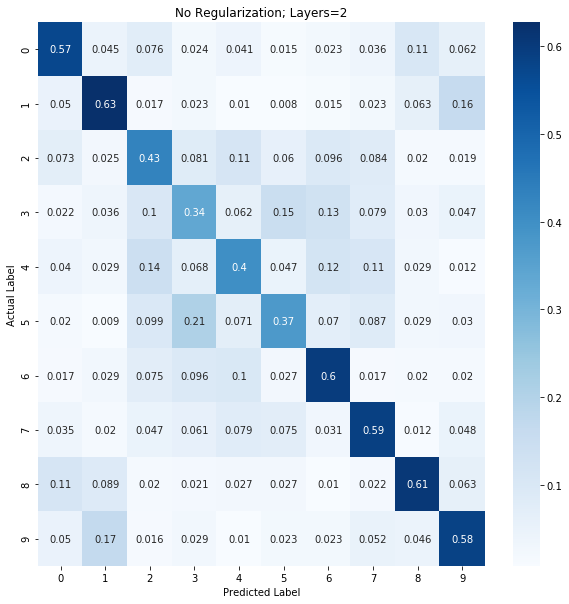

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Linear           | 4 K   
5 | model.3 | ReLU             | 0     
6 | model.4 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


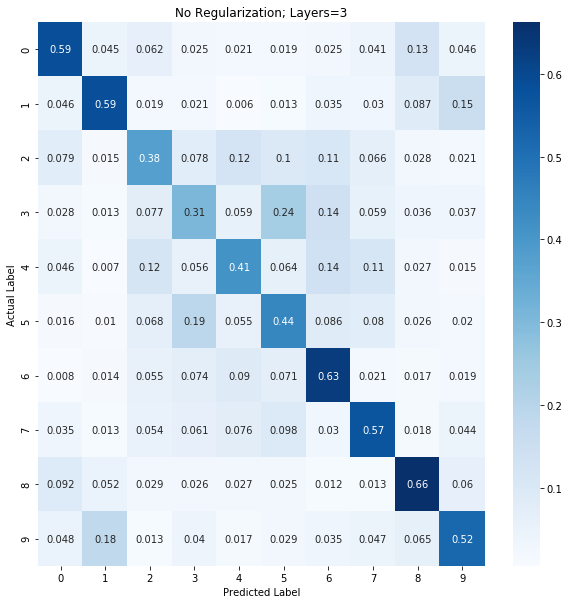

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 205 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Linear           | 4 K   
5 | model.3 | ReLU             | 0     
6 | model.4 | Linear           | 4 K   
7 | model.5 | ReLU             | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


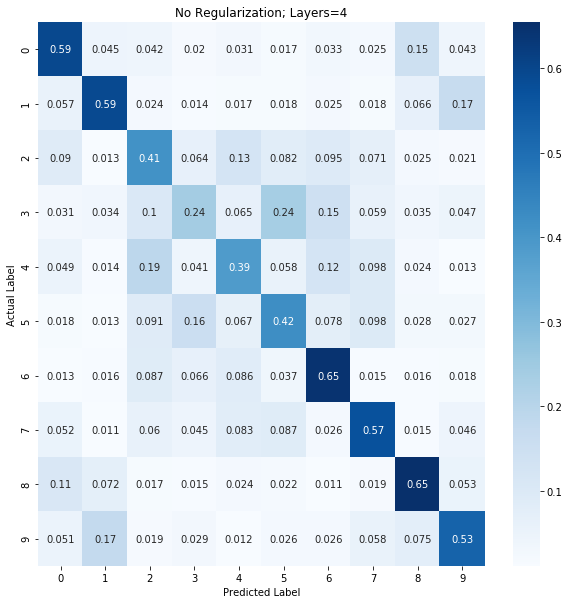

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 209 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | ReLU             | 0     
4  | model.2 | Linear           | 4 K   
5  | model.3 | ReLU             | 0     
6  | model.4 | Linear           | 4 K   
7  | model.5 | ReLU             | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | ReLU             | 0     
10 | model.8 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


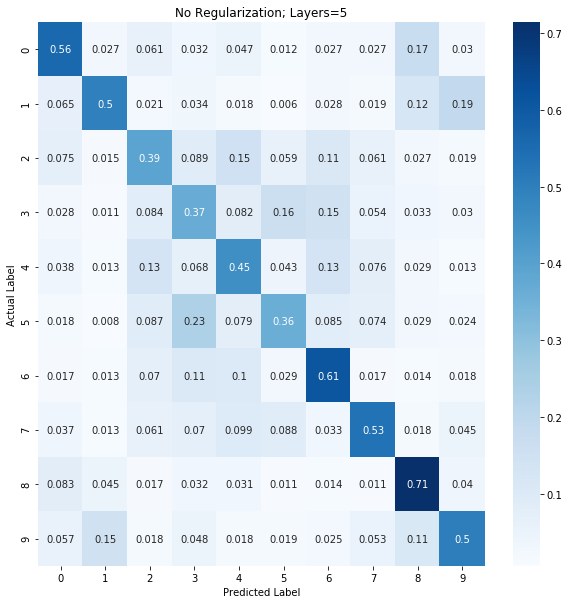

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 213 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Linear           | 4 K   
5  | model.3  | ReLU             | 0     
6  | model.4  | Linear           | 4 K   
7  | model.5  | ReLU             | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Linear           | 4 K   
11 | model.9  | ReLU             | 0     
12 | model.10 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


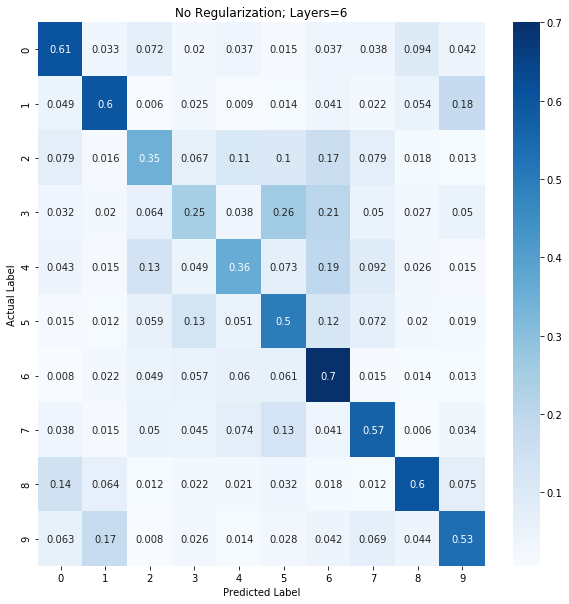

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 218 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Linear           | 4 K   
5  | model.3  | ReLU             | 0     
6  | model.4  | Linear           | 4 K   
7  | model.5  | ReLU             | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Linear           | 4 K   
11 | model.9  | ReLU             | 0     
12 | model.10 | Linear           | 4 K   
13 | model.11 | ReLU             | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


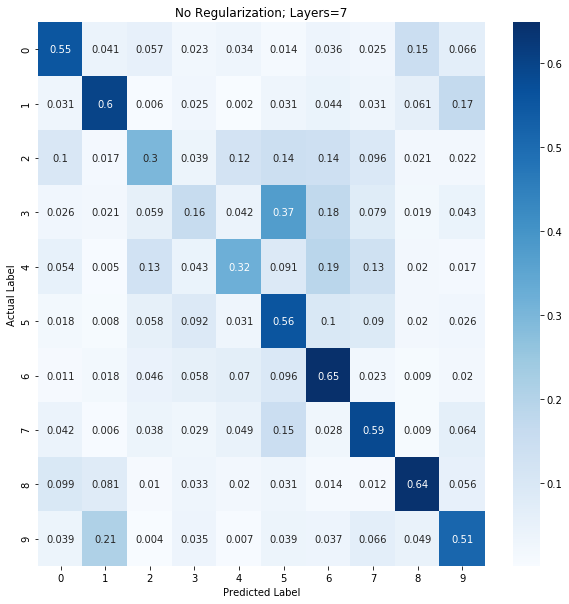

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 222 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Linear           | 4 K   
5  | model.3  | ReLU             | 0     
6  | model.4  | Linear           | 4 K   
7  | model.5  | ReLU             | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Linear           | 4 K   
11 | model.9  | ReLU             | 0     
12 | model.10 | Linear           | 4 K   
13 | model.11 | ReLU             | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


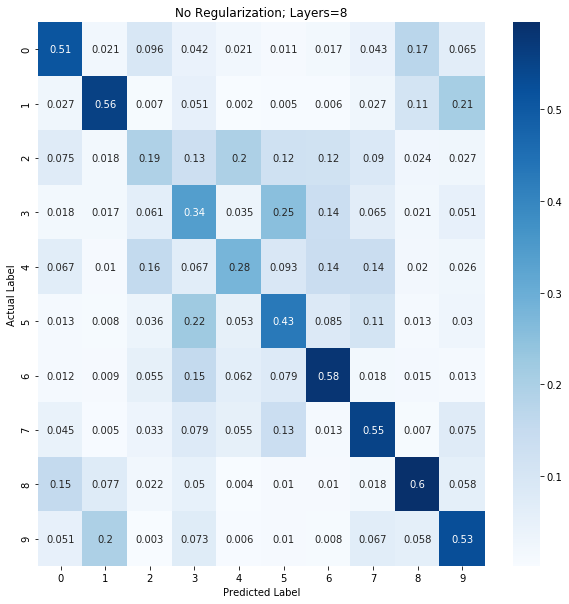

CPU times: user 20min 38s, sys: 3min 15s, total: 23min 53s
Wall time: 26min 20s


In [10]:
%%time

# Adjust Layer Depth from 2 to 6 and watch where learning degrades

experiment_layer_sizes(
    layer_size_range=range(2, 9),
    tensorboard_graph_name="layers-no_regularization",
    confusion_matrix_title="No Regularization",
    dropout=False,
)


### 2.2 With Regularization

In [2]:
%tensorboard --logdir lightning_logs/layers-add_regularization

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


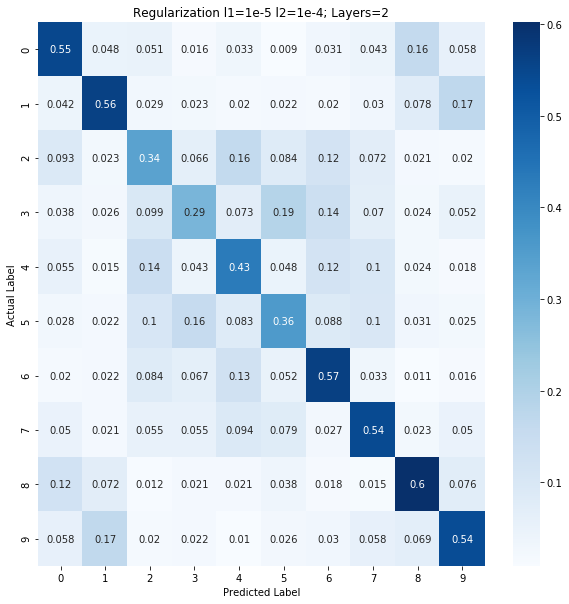

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 4 K   
6 | model.4 | ReLU             | 0     
7 | model.5 | Dropout          | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


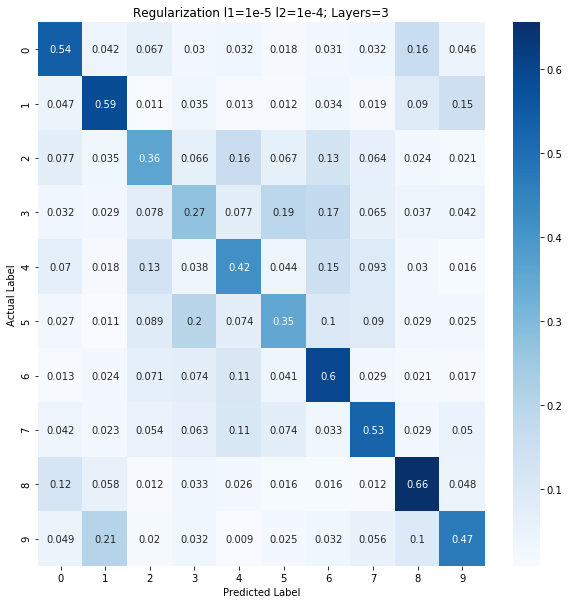

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 205 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | ReLU             | 0     
4  | model.2 | Dropout          | 0     
5  | model.3 | Linear           | 4 K   
6  | model.4 | ReLU             | 0     
7  | model.5 | Dropout          | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | ReLU             | 0     
10 | model.8 | Dropout          | 0     
11 | model.9 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


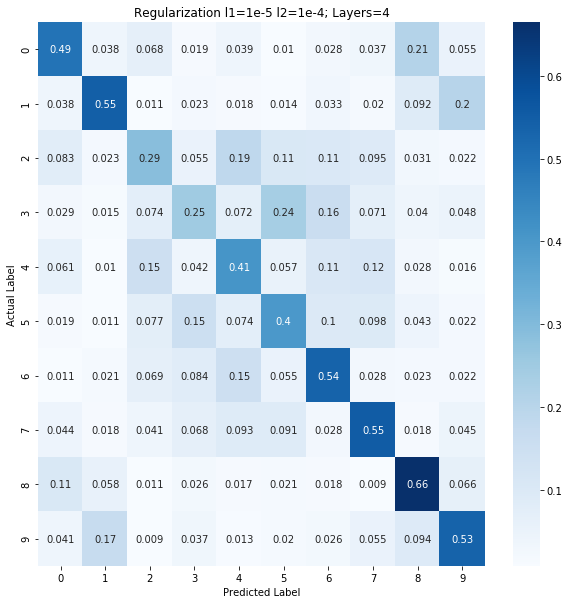

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


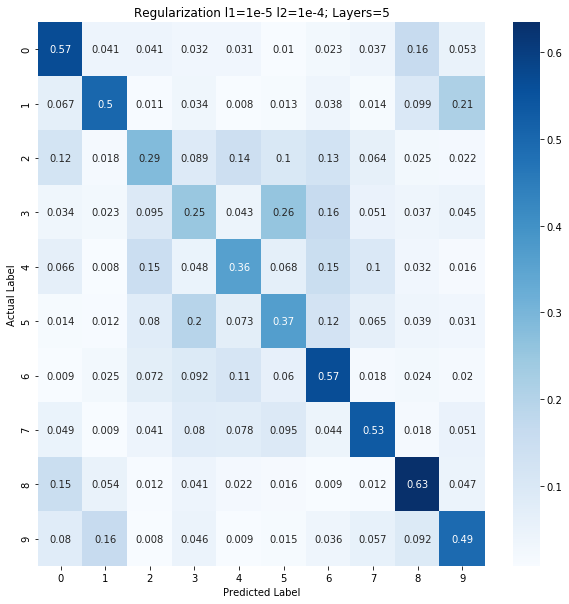

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 213 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


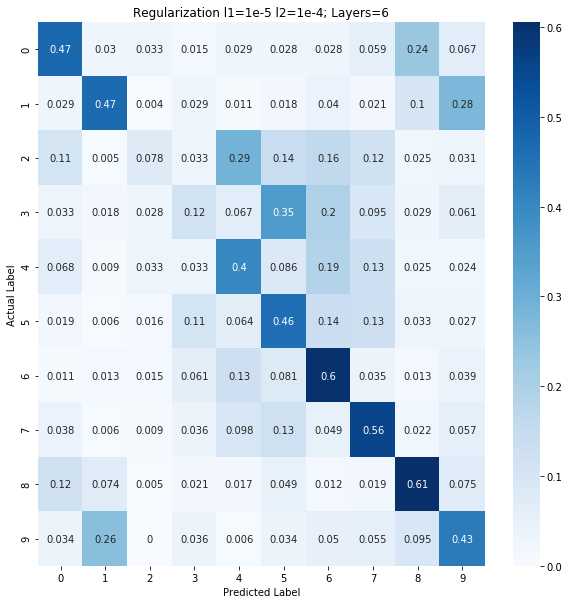

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 218 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 4 K   
18 | model.16 | ReLU             | 0     
1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


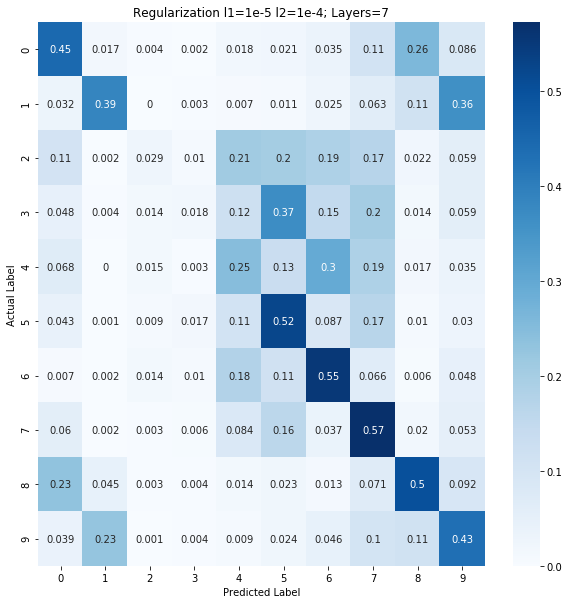

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 222 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 4 K   
18 | model.16 | ReLU             | 0     
1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


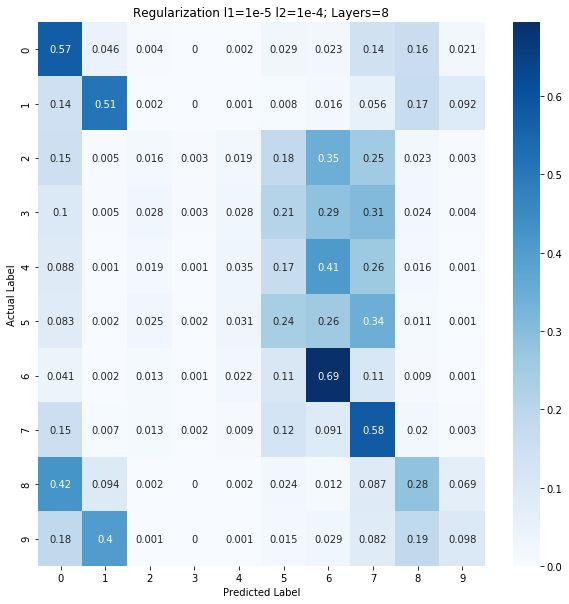

CPU times: user 31min 32s, sys: 3min 13s, total: 34min 45s
Wall time: 34min 57s


In [12]:
%%time

experiment_layer_sizes(
    layer_size_range=range(2, 9),
    tensorboard_graph_name="layers-add_regularization",
    confusion_matrix_title="Regularization l1=1e-5 l2=1e-4",
    l1_lambda=1e-5,
    l2_lambda=1e-4,
    dropout=True,
)

### 2.2 With Higher Regularization

In [4]:
%tensorboard --logdir lightning_logs/layers-high_regularization

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


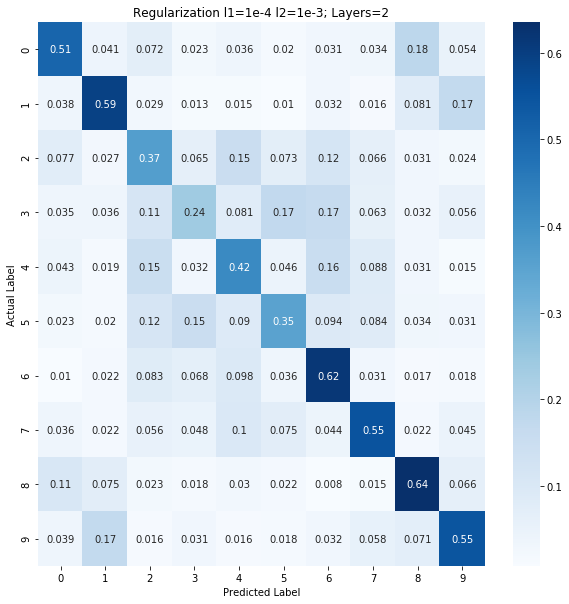

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 4 K   
6 | model.4 | ReLU             | 0     
7 | model.5 | Dropout          | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


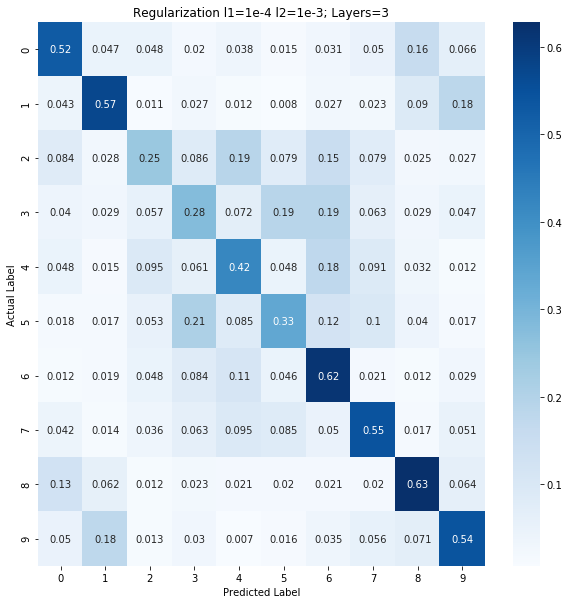

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 205 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | ReLU             | 0     
4  | model.2 | Dropout          | 0     
5  | model.3 | Linear           | 4 K   
6  | model.4 | ReLU             | 0     
7  | model.5 | Dropout          | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | ReLU             | 0     
10 | model.8 | Dropout          | 0     
11 | model.9 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


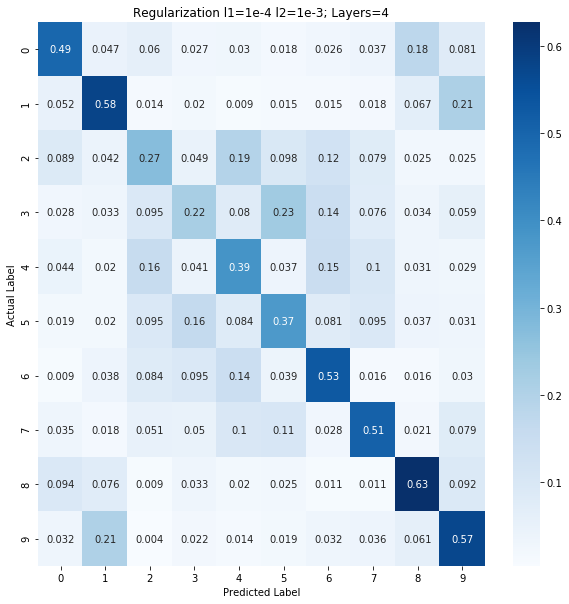

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


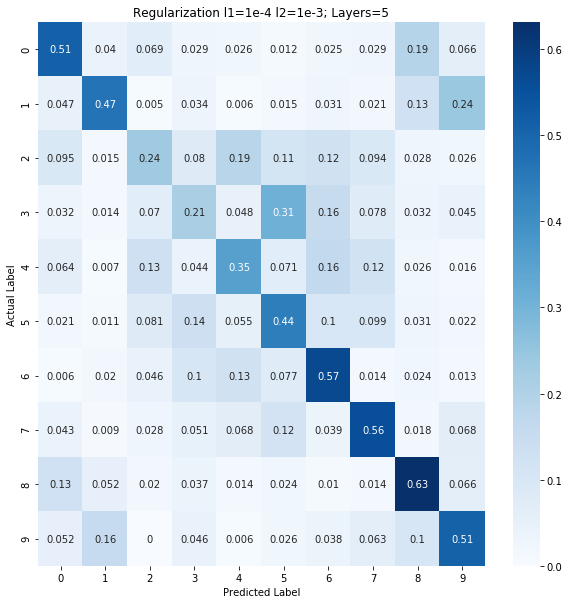

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 213 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


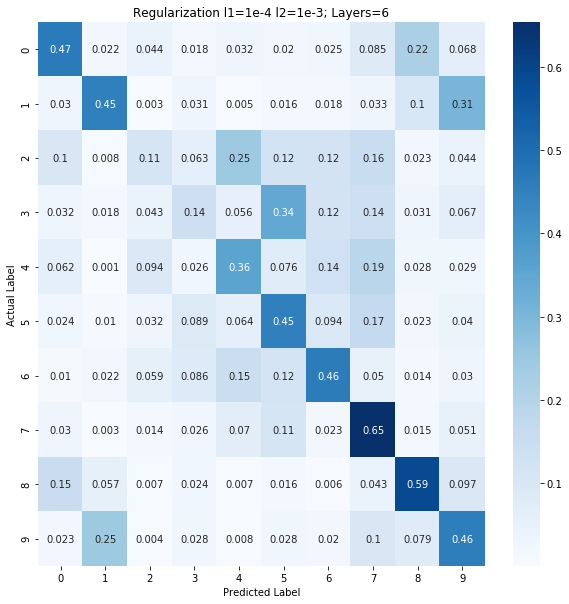

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 218 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 4 K   
18 | model.16 | ReLU             | 0     
1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


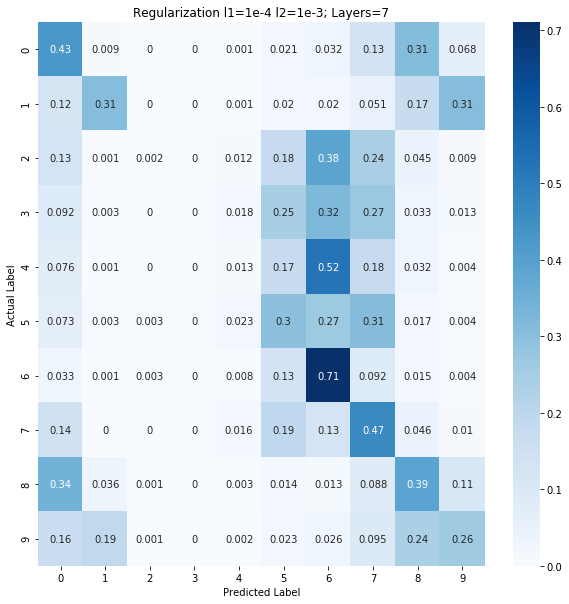

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 222 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 4 K   
15 | model.13 | ReLU             | 0     
16 | model.14 | Dropout          | 0     
17 | model.15 | Linear           | 4 K   
18 | model.16 | ReLU             | 0     
1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


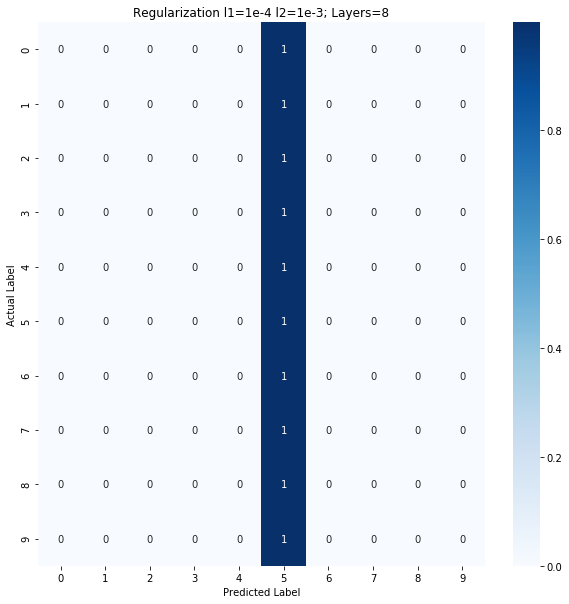

CPU times: user 31min 34s, sys: 3min 13s, total: 34min 48s
Wall time: 34min 59s


In [14]:
%%time

experiment_layer_sizes(
    layer_size_range=range(2, 9),
    tensorboard_graph_name="layers-high_regularization",
    confusion_matrix_title="Regularization l1=1e-4 l2=1e-3",
    l1_lambda=1e-4,
    l2_lambda=1e-3,
    dropout=True,
)


### 3. Task: Experiment with Different Optimizers ("SGD", "Adam", "Adagrad", "Adadelta", "RMSprop")
---

In [8]:
def experiment_optimizers(optimizers, layer_sz):
    for optimizer in optimizers:
        run_experiment(
            tensorboard_graph_name=f"optimizer_experiment/depth-{layer_sz}/{optimizer}",
            num_layers=layer_sz,
            optimizer=optimizer,
            loss_fn=torch.nn.CrossEntropyLoss(),
            activation=torch.nn.ReLU,
            l1_lambda=1e-5,
            l2_lambda=1e-4,
            dropout=True,
        )

In [5]:
%tensorboard --logdir lightning_logs/optimizer_experiment

In [10]:
# Different Optimizers

experiment_optimizers(
    optimizers=["SGD_no_momentum", "SGD", "Adam", "Adagrad", "Adadelta", "RMSprop"],
    layer_sz=5,
)


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/dhruvang/Applications/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU         

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type             | Params
------------------------------------------
0  | loss     | CrossEntropyLoss | 0     
1  | model    | Sequential       | 209 K 
2  | model.0  | Linear           | 196 K 
3  | model.1  | ReLU             | 0     
4  | model.2  | Dropout          | 0     
5  | model.3  | Linear           | 4 K   
6  | model.4  | ReLU             | 0     
7  | model.5  | Dropout          | 0     
8  | model.6  | Linear           | 4 K   
9  | model.7  | ReLU             | 0     
10 | model.8  | Dropout          | 0     
11 | model.9  | Linear           | 4 K   
12 | model.10 | ReLU             | 0     
13 | model.11 | Dropout          | 0     
14 | model.12 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 4. Task: Experiment with Different Activations ("Sigmoid", "Tanh", "ReLU")
---

#### Observation

When we increased the depth of the network, we saw that the stacking sigmoid activations caused the learning to slow down and stagnate much earlier. The other activations did not display this behaviour.

In [18]:
def experiment_activations(activations, layer_sz, **kargs):
    for activation_name, activation in activations.items():
        run_experiment(
            tensorboard_graph_name=f"activations/layers_{layer_sz}/{activation_name}",
            num_layers=layer_sz,
            optimizer="SGD",
            loss_fn=torch.nn.CrossEntropyLoss(),
            activation=activation,
            l1_lambda=1e-5,
            l2_lambda=1e-4,
            dropout=True,
        )

In [6]:
%tensorboard --logdir lightning_logs/activations

In [20]:
%%time

# Different Activations

activations = {
    "Sigmoid": torch.nn.Sigmoid,
    "Tanh": torch.nn.Tanh,
    "ReLU": torch.nn.ReLU
}

experiment_activations(
    activations=activations,
    layer_sz=2,
)


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | Sigmoid          | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | Tanh             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 197 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CPU times: user 9min 43s, sys: 1min 27s, total: 11min 11s
Wall time: 11min 48s


In [21]:
%%time

# Different Activations

experiment_activations(
    activations=activations,
    layer_sz=3,
)


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | Sigmoid          | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 4 K   
6 | model.4 | Sigmoid          | 0     
7 | model.5 | Dropout          | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | Tanh             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 4 K   
6 | model.4 | Tanh             | 0     
7 | model.5 | Dropout          | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
-----------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | Sequential       | 201 K 
2 | model.0 | Linear           | 196 K 
3 | model.1 | ReLU             | 0     
4 | model.2 | Dropout          | 0     
5 | model.3 | Linear           | 4 K   
6 | model.4 | ReLU             | 0     
7 | model.5 | Dropout          | 0     
8 | model.6 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CPU times: user 11min 12s, sys: 1min 27s, total: 12min 39s
Wall time: 12min 53s


In [22]:
%%time

# Different Activations

experiment_activations(
    activations=activations,
    layer_sz=4,
)


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 205 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | Sigmoid          | 0     
4  | model.2 | Dropout          | 0     
5  | model.3 | Linear           | 4 K   
6  | model.4 | Sigmoid          | 0     
7  | model.5 | Dropout          | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | Sigmoid          | 0     
10 | model.8 | Dropout          | 0     
11 | model.9 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 205 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | Tanh             | 0     
4  | model.2 | Dropout          | 0     
5  | model.3 | Linear           | 4 K   
6  | model.4 | Tanh             | 0     
7  | model.5 | Dropout          | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | Tanh             | 0     
10 | model.8 | Dropout          | 0     
11 | model.9 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type             | Params
-----------------------------------------
0  | loss    | CrossEntropyLoss | 0     
1  | model   | Sequential       | 205 K 
2  | model.0 | Linear           | 196 K 
3  | model.1 | ReLU             | 0     
4  | model.2 | Dropout          | 0     
5  | model.3 | Linear           | 4 K   
6  | model.4 | ReLU             | 0     
7  | model.5 | Dropout          | 0     
8  | model.6 | Linear           | 4 K   
9  | model.7 | ReLU             | 0     
10 | model.8 | Dropout          | 0     
11 | model.9 | Linear           | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CPU times: user 12min 30s, sys: 1min 26s, total: 13min 56s
Wall time: 14min 3s


### 5. Task: Implement own version of SoftmaxLoss and HingeLoss
---

>Note: We use torch.nn.Module just so that we are able to plug our loss functions without changing code in our BaseConfigurationModule class

In [23]:
def experiment_losses(
    loss_fn, tensorboard_graph_name, confusion_matrix_title,
):

    run_experiment(
        tensorboard_graph_name=tensorboard_graph_name,
        confusion_matrix_title=confusion_matrix_title,
        num_layers=4,
        optimizer="SGD",
        loss_fn=loss_fn,
        activation=torch.nn.ReLU,
        l1_lambda=1e-5,
        l2_lambda=1e-4,
        dropout=True,
    )

In [7]:
%tensorboard --logdir lightning_logs/custom_loss

### 5.1 Softmax Loss

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type        | Params
------------------------------------
0  | loss    | SoftmaxLoss | 0     
1  | model   | Sequential  | 205 K 
2  | model.0 | Linear      | 196 K 
3  | model.1 | ReLU        | 0     
4  | model.2 | Dropout     | 0     
5  | model.3 | Linear      | 4 K   
6  | model.4 | ReLU        | 0     
7  | model.5 | Dropout     | 0     
8  | model.6 | Linear      | 4 K   
9  | model.7 | ReLU        | 0     
10 | model.8 | Dropout     | 0     
11 | model.9 | Linear      | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


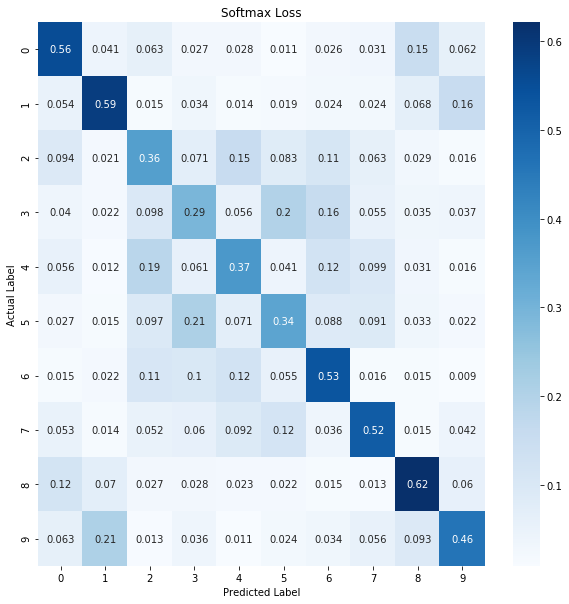

In [25]:
class SoftmaxLoss(torch.nn.Module):
    def forward(self, predictions, target):
        _exponents = torch.exp(predictions)
        _softmax = torch.div(_exponents, (torch.sum(_exponents, dim=1, keepdim=True)))
        loss = torch.log(_softmax[[range(len(predictions))], target])
        return -loss.mean()

    def __str__(self):
        return "SoftmaxLoss"


experiment_losses(
    loss_fn=SoftmaxLoss(),
    tensorboard_graph_name="custom_loss/softmax_loss",
    confusion_matrix_title="Softmax Loss",
)

### 5.2 Hinge Loss

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type       | Params
-----------------------------------
0  | loss    | HingeLoss  | 0     
1  | model   | Sequential | 205 K 
2  | model.0 | Linear     | 196 K 
3  | model.1 | ReLU       | 0     
4  | model.2 | Dropout    | 0     
5  | model.3 | Linear     | 4 K   
6  | model.4 | ReLU       | 0     
7  | model.5 | Dropout    | 0     
8  | model.6 | Linear     | 4 K   
9  | model.7 | ReLU       | 0     
10 | model.8 | Dropout    | 0     
11 | model.9 | Linear     | 650   


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


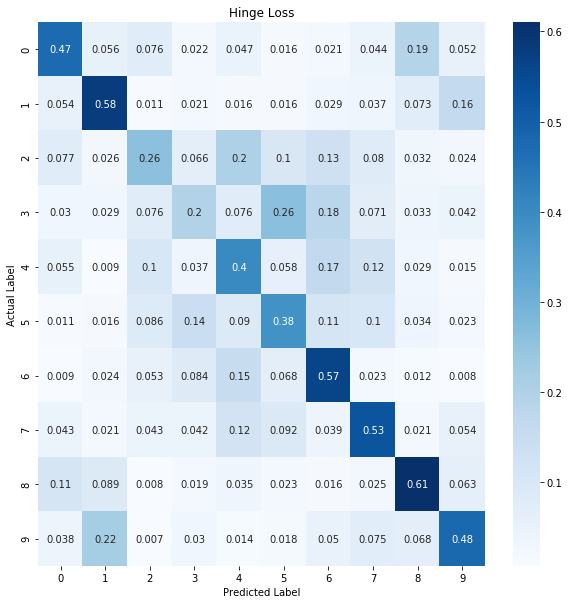

In [26]:
class HingeLoss(torch.nn.Module):
    def forward(self, predictions, target):
        loss = torch.clamp(
            predictions
            - predictions[[range(len(predictions))], target].view(-1, 1)
            + 1,
            min=0,
        )
        loss[[range(len(predictions))], target] = 0
        return loss.mean()

    def __str__(self):
        return "HingeLoss"


experiment_losses(
    loss_fn=HingeLoss(),
    tensorboard_graph_name="custom_loss/hinge_loss",
    confusion_matrix_title="Hinge Loss",
)